# Compare alternative decision rules on a value diagram

In [1]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [9]:
import sys
from matplotlib import pyplot as plt
import pickle
import bz2
import numpy as np

sys.path.append('..')

from ruv.relative_utility_value import relative_utility_value
from ruv.damage_functions import binary
from ruv.economic_models import cost_loss, cost_loss_analytical_spend
from ruv.utility_functions import cara
from ruv.decision_rules import optimise_over_forecast_distribution, critical_probability_threshold_equals_par, critical_probability_threshold_fixed, critical_probability_threshold_max_value

# Example forecast dataset
### Day 1 to 7 forecasts for catchment in southern Murray-Darling basin generated using the MuTHRE method

In [4]:
dataset_filepath = '401012_data.pickle.bz2'

with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'], data['fcst']

print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 484)


# Define decision context

In [35]:
alpha_step = 0.02
alphas = np.arange(alpha_step, 1, alpha_step)
decision_threshold = np.nanquantile(obs, 0.75)

decision_definition = {
    'damage_function': [binary, {'max_loss': 1, 'min_loss': 0, 'threshold': decision_threshold}],
    'utility_function': [cara, {'A': 0}],
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'decision_thresholds': np.insert([decision_threshold], 0, 0),
}

# note there is no decision_rule defined, we will add this before calling relative_utility_value(..)

In [44]:
# use obs to simulate using event frequency (as in REV)
ref = None

# Calculate RUV using different decision rules

In [ ]:
parallel_nodes = 8

In [37]:
decision_definition['decision_rule'] = [optimise_over_forecast_distribution, None]
results_optim = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [38]:
decision_definition['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.1}]
results_fixed_10th = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [39]:
decision_definition['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.5}]
results_fixed_50th = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [40]:
decision_definition['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.9}]
results_fixed_90th = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [41]:
decision_definition['decision_rule'] = [critical_probability_threshold_max_value, None]
results_max = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

In [42]:
decision_definition['decision_rule'] = [critical_probability_threshold_equals_par, None]
results_alpha = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes)

# Plot results on a value diagram

In [45]:
# make a pandas dataframe and then use that to make the plot - clearer code

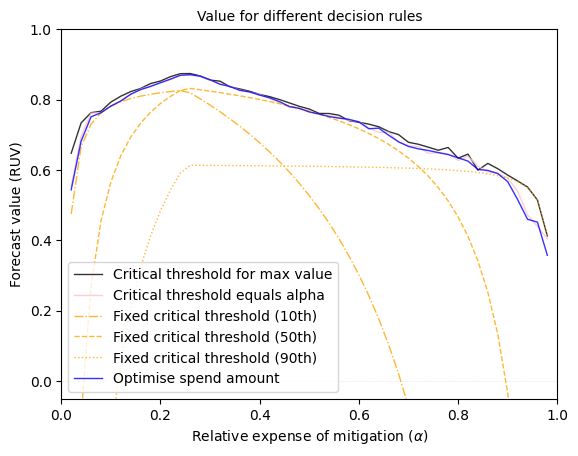

In [46]:
plt.plot(alphas, results_max['ruv'], color='black', linewidth=1, alpha=0.8, label='Critical threshold for max value')
plt.plot(alphas, results_alpha['ruv'], color='pink', linewidth=1, alpha=0.8, label='Critical threshold equals alpha')
plt.plot(alphas, results_fixed_10th['ruv'], color='orange', linestyle='-.', linewidth=1, alpha=0.8, label='Fixed critical threshold (10th)')
plt.plot(alphas, results_fixed_50th['ruv'], color='orange', linestyle='--', linewidth=1, alpha=0.8, label='Fixed critical threshold (50th)')
plt.plot(alphas, results_fixed_90th['ruv'], color='orange', linestyle=':', linewidth=1, alpha=0.8, label='Fixed critical threshold (90th)')
plt.plot(alphas, results_optim['ruv'], color='blue', linewidth=1, alpha=0.8, label='Optimise spend amount')
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.xlim((0, 1))
plt.ylim(-0.05, 1)
plt.xlabel(r'Relative expense of mitigation ($\alpha$)')
plt.ylabel('Forecast value (RUV)') 
plt.title('Value for different decision rules', fontsize='medium')
plt.legend()